<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from xgboost import XGBClassifier
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import log_loss

In [2]:
def pref_attach_follower(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
             return 0
        pref = len(set(train_graph.predecessors(a))) * len(set(train_graph.predecessors(b)))
    except:
        return 0
    return pref

In [3]:
def pref_attach_followee(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
             return 0
        pref = len(set(train_graph.successors(a))) * len(set(train_graph.successors(b)))
    except:
        return 0
    return pref

In [4]:
def svd_dot(x,y,S):
    try:
        s = sadj_dict[x]
        d = sadj_dict[y]
        return S[s].dot(S[d])
    except:
        return 0

In [5]:
train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [6]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [7]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [8]:
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [9]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')
df_final_train.head()

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,...,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,...,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,...,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09
2,1325247,760242,1,0,0.369565,0.156957,0.566038,28,41,22,...,-2.380564e-19,-7.021227e-19,1.940403e-19,-3.365389e-19,-1.238370e-18,1.438175e-19,-1.852863e-19,-5.901864e-19,1.629341e-19,-2.572452e-19
3,1368400,1006992,1,0,0.000000,0.000000,0.000000,11,5,7,...,6.058498e-11,1.514614e-11,1.513483e-12,4.498061e-13,-9.818087e-10,3.454672e-11,5.213635e-08,9.595823e-13,3.047045e-10,1.246592e-13
4,140165,1708748,1,0,0.000000,0.000000,0.000000,1,11,3,...,1.197283e-07,1.999809e-14,3.360247e-13,1.407670e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


1 . Adding feature for preferential attachment

In [11]:
df_final_train['pref_attach_follower'] = df_final_train.apply(lambda row: pref_attach_follower(row['source_node'],row['destination_node']),axis=1)
df_final_test['pref_attach_follower'] = df_final_test.apply(lambda row: pref_attach_follower(row['source_node'],row['destination_node']),axis=1)

In [10]:
df_final_train['pref_attach_followee'] = df_final_train.apply(lambda row: pref_attach_followee(row['source_node'],row['destination_node']),axis=1)
df_final_test['pref_attach_followee'] = df_final_test.apply(lambda row: pref_attach_followee(row['source_node'],row['destination_node']),axis=1)

2. Adding feature for svd.dot

In [12]:
df_final_train['svd_dot_u'] = df_final_train.apply(lambda row: svd_dot(row['source_node'],row['destination_node'],U),axis=1)
df_final_test['svd_dot_u'] = df_final_test.apply(lambda row: svd_dot(row['source_node'],row['destination_node'],U),axis=1)

df_final_train['svd_dot_v'] = df_final_train.apply(lambda row: svd_dot(row['source_node'],row['destination_node'],V),axis=1)
df_final_test['svd_dot_v'] = df_final_test.apply(lambda row: svd_dot(row['source_node'],row['destination_node'],V),axis=1)

In [13]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [14]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

3. Training XGBoost on the new dataframe

In [15]:
x_clf=XGBClassifier()

params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_clf1=RandomizedSearchCV(x_clf,param_distributions=params,verbose=10,n_jobs=-1,)
random_clf1.fit(df_final_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 52.1min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 54.1min finished


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_al...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distrib

In [16]:
print (random_clf1.best_params_)

{'subsample': 1, 'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


In [17]:
x_clf=XGBClassifier(n_estimators=200, learning_rate=0.2, colsample_bytree=1, max_depth=10, subsample= 0.3)
x_clf.fit(df_final_train,y_train)
c_clf=CalibratedClassifierCV(x_clf,method='sigmoid')
c_clf.fit(df_final_train,y_train)

predict_y_tr = c_clf.predict_proba(df_final_train)
predict_y_te = c_clf.predict_proba(df_final_test)
print ('train loss',log_loss(y_train, predict_y_tr))
print ('test loss',log_loss(y_test, predict_y_te))

train loss 0.01905973508494769
test loss 0.27063535730233396


Various error metrics

In [18]:
y_train_pred = c_clf.predict(df_final_train)
y_test_pred = c_clf.predict(df_final_test)
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9999700308682058
Test f1 score 0.9260233297985153


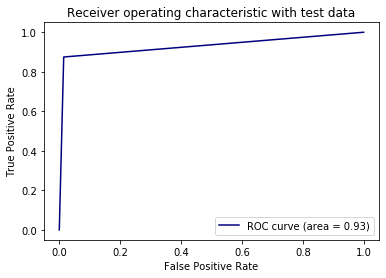

In [19]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()